In [243]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
from colorama import Fore
import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import mplcyberpunk
from prophet import Prophet
import warnings # Supress warnings 
warnings.filterwarnings('ignore')

In [34]:
data = pd.read_excel("Data/Crime Calls Data.xlsx")

In [50]:
statistical_df = data.copy()
predictive_df = data.copy()

In [51]:
statistical_df.sample(n=5)

,report_date,report_time,location,category,sub_category,x_cord,y_cord,ps_division,ps_station,year,month,shift,case_id,contact_no
136142,2020-10-20,09:00:33,service hospital OPD,THEFT,OTHER THEFT,74.334131,31.539883,MODEL TOWN,PS Shadman,2020,October,A,20201020090034000004,03246042346
146912,2020-11-26,21:49:12,"Allama Iqbal road, Zeshan Homeopathic store",ROBBERY,SHOP ROBBERY,74.339433,31.570402,CIVIL LINES,PS Gari Shaho,2020,November,B,20201126214912000008,03008005495
420331,2024-03-04,22:51:35,zaitoon colony daroga wala chowk gas factory,MOTORCYCLE THEFT,MOTORCYCLE THEFT,74.399326,31.587300,CANTT,PS Baghbanpura,2024,March,C,20240304225135000015,03224272931
63505,2020-01-29,10:38:40.000,madina colony walton road,MOTORCYCLE THEFT,Motorcycle Theft,74.365165,31.489304,CANTT,PS Factory Area,2020,January,A,NaN,NaN
264332,2021-11-12,15:34:17,malik chowk,THEFT,THEFT CAUGHT,74.365213,31.481944,CANTT,PS Factory Area,2021,November,B,20211112153418000010,03062091108


In [ ]:
statistical_df.sample(n=5)

,report_date,report_time,location,category,sub_category,x_cord,y_cord,ps_division,ps_station,year,month,shift,case_id,contact_no
136142,2020-10-20,09:00:33,service hospital OPD,THEFT,OTHER THEFT,74.334131,31.539883,MODEL TOWN,PS Shadman,2020,October,A,20201020090034000004,03246042346
146912,2020-11-26,21:49:12,"Allama Iqbal road, Zeshan Homeopathic store",ROBBERY,SHOP ROBBERY,74.339433,31.570402,CIVIL LINES,PS Gari Shaho,2020,November,B,20201126214912000008,03008005495
420331,2024-03-04,22:51:35,zaitoon colony daroga wala chowk gas factory,MOTORCYCLE THEFT,MOTORCYCLE THEFT,74.399326,31.587300,CANTT,PS Baghbanpura,2024,March,C,20240304225135000015,03224272931
63505,2020-01-29,10:38:40.000,madina colony walton road,MOTORCYCLE THEFT,Motorcycle Theft,74.365165,31.489304,CANTT,PS Factory Area,2020,January,A,NaN,NaN
264332,2021-11-12,15:34:17,malik chowk,THEFT,THEFT CAUGHT,74.365213,31.481944,CANTT,PS Factory Area,2021,November,B,20211112153418000010,03062091108


In [52]:
statistical_df.isna().sum()

report_date         0
report_time         1
location         3999
category            0
sub_category     5644
x_cord              0
y_cord              0
ps_division         0
ps_station          0
year                0
month             356
shift               1
case_id         82535
contact_no      81707
dtype: int64

`case_id` and `contact_no` have null values more than 80000 i can drop them but since they are not going to be used in the anlaysis , so i am keeping them

Since `report_time` and `shift` have 1 null value each , so i'll do forward filling in them with ffill

In [57]:
statistical_df[['report_time','shift']] = statistical_df[['report_time','shift']].fillna(method='ffill')

In [58]:
statistical_df.isna().sum()

report_date         0
report_time         0
location         3999
category            0
sub_category     5644
x_cord              0
y_cord              0
ps_division         0
ps_station          0
year                0
month             356
shift               0
case_id         82535
contact_no      81707
dtype: int64

In [68]:
statistical_df['report_time'].sample(5)

334964        12:05:33
228498    08:13:32.000
149544    09:17:34.000
419196        14:04:26
323966        00:16:13
Name: report_time, dtype: object

Some of the time values are in the wrong format like  08:10PM , 08:13:32.000 

In [73]:
def standardize_time(time_str):
  """
  Standardizes the format of a time string to HH:MM:SS.

  Args:
      time_str (str): The time string to be standardized.

  Returns:
      str: The standardized time string in HH:MM:SS format,
          or the original string if parsing fails (may indicate invalid format).
  """
  try:
    # Try parsing the time in 24-hour format (HH:MM:SS[.fff])
    return pd.to_datetime(time_str).strftime('%H:%M:%S')
  except ValueError:
    try:
      # Try parsing the time in 12-hour format (HH:MM[AP]M)
      return pd.to_datetime(time_str).strftime('%H:%M:%S')
    except ValueError:
      # If parsing fails, return the original string (may indicate invalid format)
      return time_str

In [74]:
statistical_df['report_time'] = statistical_df['report_time'].apply(standardize_time)

In [78]:
statistical_df['datetime'] = pd.to_datetime(statistical_df['report_date']+ ' ' +statistical_df['report_time'])

In [79]:
# Feature Extraction

statistical_df['hour'] = statistical_df['datetime'].dt.hour
statistical_df['day'] = statistical_df['datetime'].dt.day_name()

### Exploratory Data Analysis

In [143]:
# Categorical Dataset Grouping

categorical_grouping = statistical_df.groupby('category')['category'].size().sort_values(ascending=True)

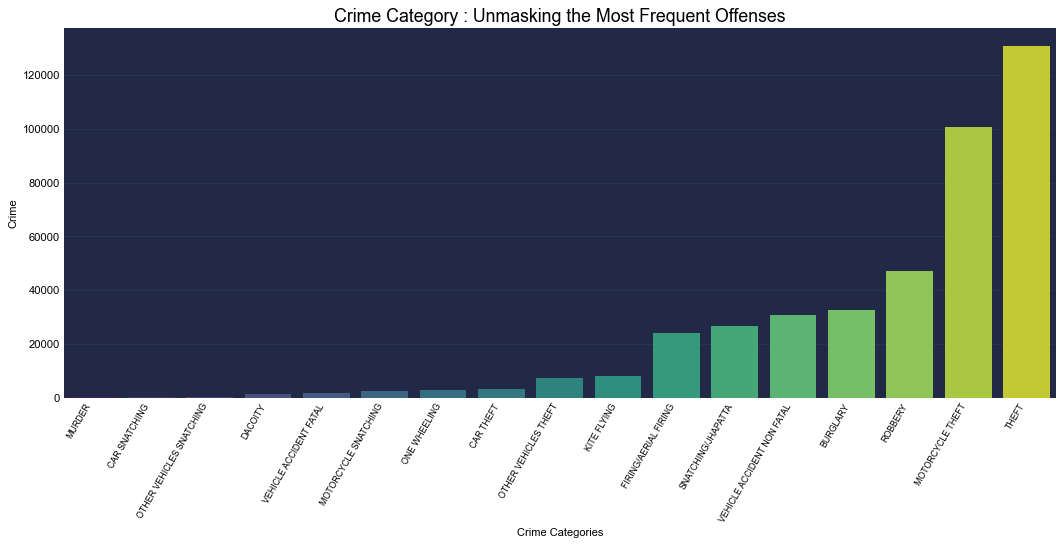

In [213]:
fig, ax = plt.subplots(figsize=(16,6), facecolor='white',dpi=80)
sns.barplot(x=categorical_grouping.index, y=categorical_grouping.values,palette="viridis")
sns.color_palette("viridis")
plt.xlabel("Crime Categories",color='black')
plt.yticks(color='black')
plt.ylabel("Crime",color='black')
plt.xticks(categorical_grouping.index,rotation=60, horizontalalignment='right', fontsize=8,color='black')
plt.title("Crime Category : Unmasking the Most Frequent Offenses", fontsize=16,color='black')
# mplcyberpunk.add_glow_effects()
plt.show()


In [123]:
policestation_crime = statistical_df.groupby('ps_station')['ps_station'].size().reset_index(name='crime').sort_values(by=['crime'] , ascending=False)[:10]

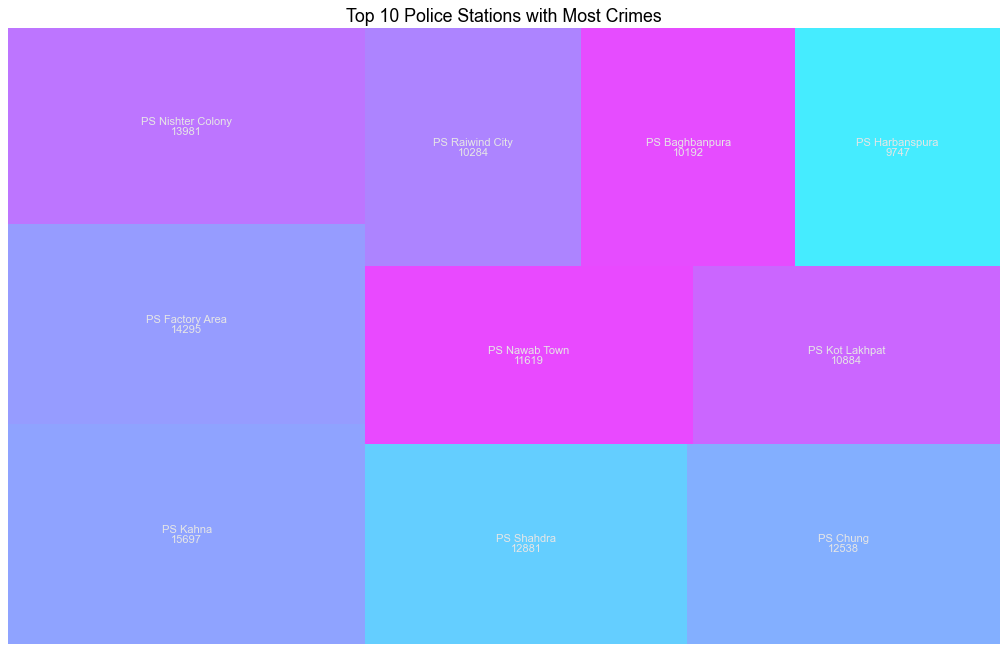

In [204]:
fig, ax = plt.subplots(figsize=(16,10), facecolor='white',dpi=80)
squarify.plot(sizes=policestation_crime.crime, label=policestation_crime.ps_station, alpha=0.8,value=policestation_crime.crime)
plt.title('Top 10 Police Stations with Most Crimes',fontsize=16 , color='black')
plt.axis('off')
plt.show()

In [168]:
# Divisional Crime for Top 3 Crime Categories

divisonal_crime = statistical_df[(statistical_df['category'] == 'THEFT') | \
                (statistical_df['category'] == 'MOTORCYCLE THEFT') |\
                (statistical_df['category'] == 'ROBBERY')]\
                .groupby('ps_division')['ps_division'].size()\
                .reset_index(name='crime')\
                .sort_values(by='crime',ascending=False)

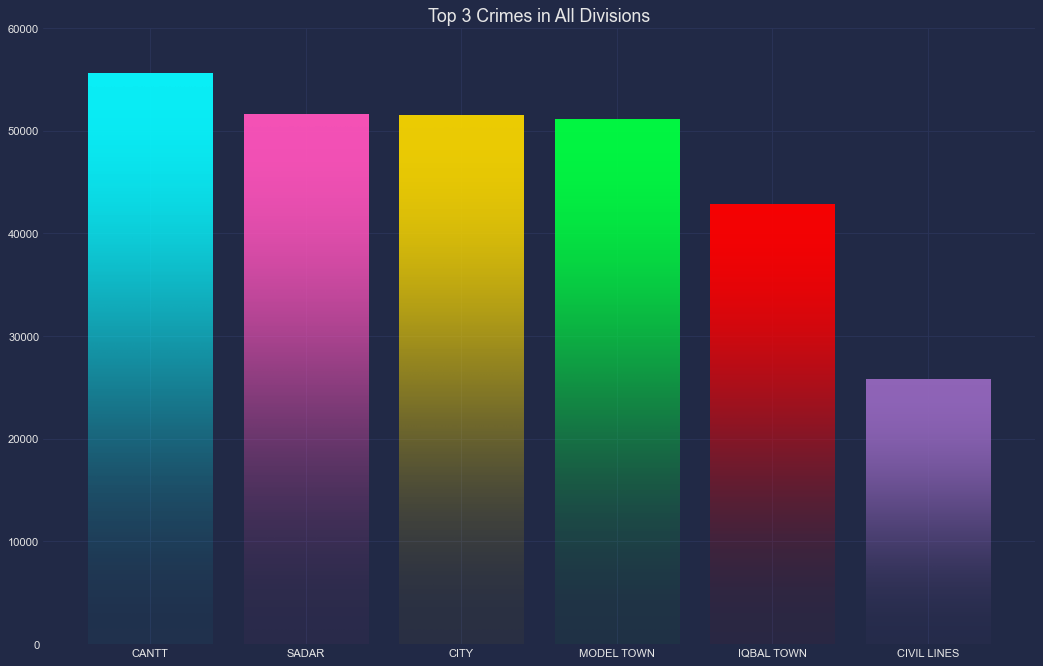

In [167]:
fig, ax = plt.subplots(figsize=(16,10),dpi=80)
plt.style.use('cyberpunk')

categories = divisonal_crime.ps_division
values = divisonal_crime.crime
colors = ["C0", "C1", "C2", "C3", "C4","C5"]

bars = plt.bar(categories, values, color=colors, zorder=2)

mplcyberpunk.add_bar_gradient(bars=bars)
plt.title("Top 3 Crimes in All Divisions", fontsize=16)
plt.ylim(0,60000)

plt.show()

In [197]:
monthly_crime  = statistical_df.groupby(['month','category'])['month']\
                .size().reset_index(name='crime')\
                .sort_values(by='month',ascending=True)

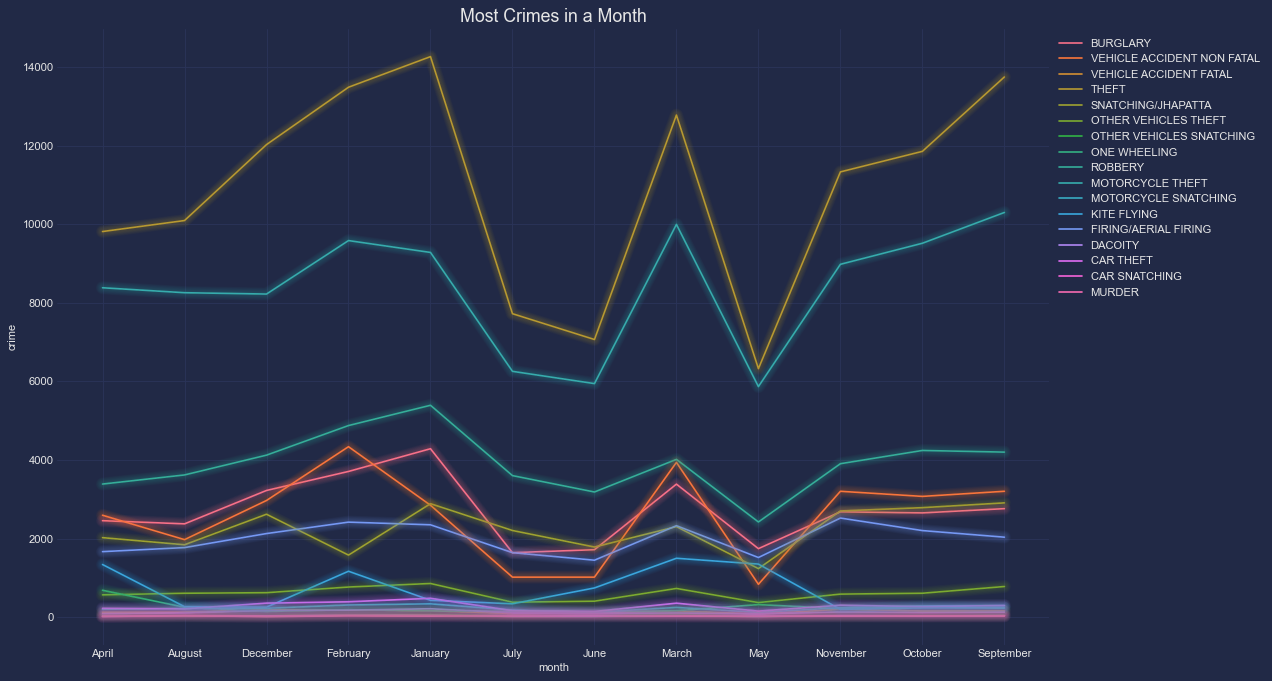

In [199]:
fig, ax = plt.subplots(figsize=(16,10),dpi=80)

sns.lineplot(x=monthly_crime['month'],y=monthly_crime['crime'],hue=monthly_crime['category'])
plt.legend(bbox_to_anchor=(1, 1))
mplcyberpunk.make_lines_glow(ax)
plt.title("Most Crimes in a Month", fontsize=16)
plt.show()

In [216]:
hourly_crime = statistical_df.groupby('hour')['hour'].size()\
                .reset_index(name="crime").sort_values(by='hour',ascending=False)


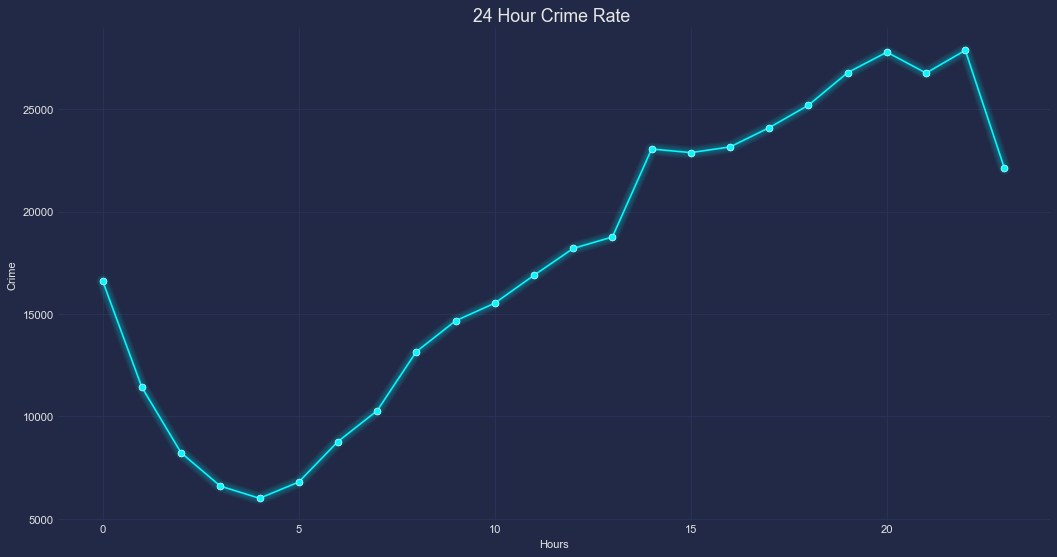

In [234]:
fig, ax = plt.subplots(figsize=(16,8),dpi=80)

sns.lineplot(x=hourly_crime['hour'],y=hourly_crime['crime'],marker="o")
plt.ylabel("Crime")
plt.xlabel("Hours")
plt.title("24 Hour Crime Rate ",fontsize=16)

mplcyberpunk.make_lines_glow(ax)
plt.show()


In [224]:
daywise_crime = statistical_df.groupby('day')['day'].size()\
                .reset_index(name="crime")\
                .sort_values(by="day",ascending=True)

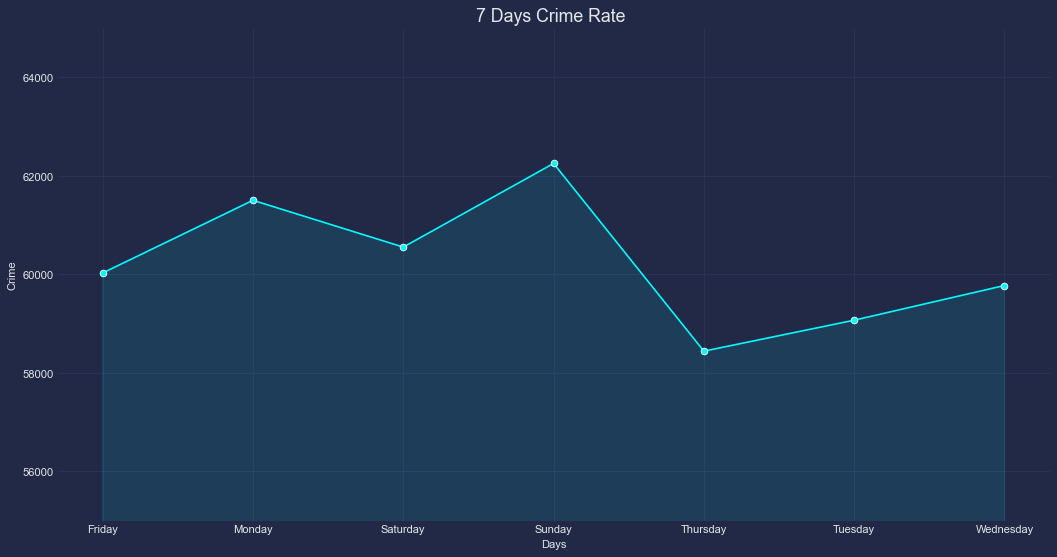

In [235]:
fig, ax = plt.subplots(figsize=(16,8),dpi=80)

sns.lineplot(x=daywise_crime['day'],y=daywise_crime['crime'],marker="o")
plt.ylabel("Crime")
plt.xlabel("Days")
plt.ylim(55000,65000)
plt.title("7 Days Crime Rate ",fontsize=16)

mplcyberpunk.add_underglow()
plt.show()


### Creating a Subset of Data for the Last 8 months ( 03 August 2023 to 08 March 2024)

In [236]:
subset_df = predictive_df[predictive_df['report_date'] >= '2023-07-01']

In [237]:
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88179 entries, 333421 to 421599
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   report_date   88179 non-null  object 
 1   report_time   88179 non-null  object 
 2   location      85749 non-null  object 
 3   category      88179 non-null  object 
 4   sub_category  87551 non-null  object 
 5   x_cord        88179 non-null  float64
 6   y_cord        88179 non-null  float64
 7   ps_division   88179 non-null  object 
 8   ps_station    88179 non-null  object 
 9   year          88179 non-null  int64  
 10  month         88179 non-null  object 
 11  shift         88179 non-null  object 
 12  case_id       88179 non-null  object 
 13  contact_no    88165 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 10.1+ MB


In [238]:
subset_df['report_date'].value_counts()

report_date
2023-09-06    692
2023-09-07    683
2023-09-08    660
2023-09-11    624
2023-09-15    622
             ... 
2023-07-20     32
2023-07-29     31
2023-07-01     13
2024-02-23     10
2023-08-08      3
Name: count, Length: 248, dtype: int64

In [239]:
subset_df['report_date'] = pd.to_datetime(subset_df['report_date'])

In [241]:
subset_df = subset_df.groupby('report_date')['report_date'].size()\
            .reset_index(name="crime")\
            .sort_values(by="report_date",ascending=True)
subset_df.rename(columns={'report_date':'ds','crime':'y'},inplace=True)

In [242]:
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      248 non-null    datetime64[ns]
 1   y       248 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.0 KB


In [ ]:
model = Prophet()

In [29]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [ ]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)]) 